In [1]:
# Tensorlayer version == 1.11.1
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add, LeakyReLU, Lambda
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.activations import sigmoid
from keras.layers.convolutional import UpSampling2D, Conv2D,Conv2DTranspose
from keras.applications import VGG19
from keras.models import Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot
from keras.callbacks import TensorBoard, ModelCheckpoint
from glob import glob
from tqdm import tqdm_notebook
import scipy
import imageio
from tensorlayer.prepro import *
import tensorlayer as tl
from keras import initializers
from keras import backend as K
import tensorflow as tf
import h5py
import cv2

Using TensorFlow backend.


In [2]:
batch_size = 16
optimizer = Adam(lr=0.0001, beta_1=0.9)
ni = np.sqrt(batch_size)
hr_shape = (224,224,3)
lr_shape = (56,56,3)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.depth_to_space(x, scale)


    return Lambda(subpixel, output_shape=subpixel_shape)

In [4]:
def Generator(lr_shape,is_train=True):
    lr_input = Input(shape=lr_shape,name="in")
    n = Conv2D(64, kernel_size=9, strides=1, padding='same', name='n64s1/c')(lr_input)
    n = PReLU()(n)
    temp = n
    # Res blocks
    i=1
    nn = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/1')(n)
    nn = BatchNormalization(name='n64s1/b1/%s' % i)(nn)
    nn = PReLU()(nn)
    nn = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn)
    nn = BatchNormalization(name='n64s1/b2/%s' % i)(nn)
    nn1 = Add(name='b_residual_add/%s' % i)([nn,temp])
    
    i=2
    nn2 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/2')(nn1)
    nn2 = BatchNormalization(name='n64s1/b1/%s' % i)(nn2)
    nn2 = PReLU()(nn2)
    nn2 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn2)
    nn2 = BatchNormalization(name='n64s1/b2/%s' % i)(nn2)
    nn2 = Add(name='b_residual_add/%s' % i)([nn2,nn1])
    
    i=3
    nn3 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/3')(nn2)
    nn3 = BatchNormalization(name='n64s1/b1/%s' % i)(nn3)
    nn3 = PReLU()(nn3)
    nn3 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn3)
    nn3 = BatchNormalization(name='n64s1/b2/%s' % i)(nn3)
    nn3 = Add(name='b_residual_add/%s' % i)([nn2,nn3])
    
    i=4
    nn4 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/4')(nn3)
    nn4 = BatchNormalization(name='n64s1/b1/%s' % i)(nn4)
    nn4 = PReLU()(nn4)
    nn4 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn4)
    nn4 = BatchNormalization(name='n64s1/b2/%s' % i)(nn4)
    nn4 = Add(name='b_residual_add/%s' % i)([nn4,nn3])
    
    i=5
    nn5 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/5')(nn4)
    nn5 = BatchNormalization(name='n64s1/b1/%s' % i)(nn5)
    nn5 = PReLU()(nn5)
    nn5 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn5)
    nn5 = BatchNormalization(name='n64s1/b2/%s' % i)(nn5)
    nn5 = Add(name='b_residual_add/%s' % i)([nn5,nn4])
    
    i=6
    nn6 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/6')(nn5)
    nn6 = BatchNormalization(name='n64s1/b1/%s' % i)(nn6)
    nn6 = PReLU()(nn6)
    nn6 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn6)
    nn6 = BatchNormalization(name='n64s1/b2/%s' % i)(nn6)
    nn6 = Add(name='b_residual_add/%s' % i)([nn6,nn5])
    
    i=7
    nn7 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/7')(nn6)
    nn7 = BatchNormalization(name='n64s1/b1/%s' % i)(nn7)
    nn7 = PReLU()(nn7)
    nn7 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn7)
    nn7 = BatchNormalization(name='n64s1/b2/%s' % i)(nn7)
    nn7 = Add(name='b_residual_add/%s' % i)([nn7,nn6])
    
    i=8
    nn8 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/8')(nn7)
    nn8 = BatchNormalization(name='n64s1/b1/%s' % i)(nn8)
    nn8 = PReLU()(nn8)
    nn8 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn8)
    nn8 = BatchNormalization(name='n64s1/b2/%s' % i)(nn8)
    nn8 = Add(name='b_residual_add/%s' % i)([nn8,nn7])
    
    i=9
    nn9 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/9')(nn8)
    nn9 = BatchNormalization(name='n64s1/b1/%s' % i)(nn9)
    nn9 = PReLU()(nn9)
    nn9 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn9)
    nn9 = BatchNormalization(name='n64s1/b2/%s' % i)(nn9)
    nn9 = Add(name='b_residual_add/%s' % i)([nn9,nn8])
    
    i=10
    nn10 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/10')(nn9)
    nn10 = BatchNormalization(name='n64s1/b1/%s' % i)(nn10)
    nn10 = PReLU()(nn10)
    nn10 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn10)
    nn10 = BatchNormalization(name='n64s1/b2/%s' % i)(nn10)
    nn10 = Add(name='b_residual_add/%s' % i)([nn10,nn9])
    
    i=11
    nn11 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/11')(nn10)
    nn11 = BatchNormalization(name='n64s1/b1/%s' % i)(nn11)
    nn11 = PReLU()(nn11)
    nn11 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn11)
    nn11 = BatchNormalization(name='n64s1/b2/%s' % i)(nn11)
    nn11 = Add(name='b_residual_add/%s' % i)([nn11,nn10])
    
    i=12
    nn12 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/12')(nn11)
    nn12 = BatchNormalization(name='n64s1/b1/%s' % i)(nn12)
    nn12 = PReLU()(nn12)
    nn12 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn12)
    nn12 = BatchNormalization(name='n64s1/b2/%s' % i)(nn12)
    nn12 = Add(name='b_residual_add/%s' % i)([nn12,nn11])
    
    i=13
    nn13 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/13')(nn12)
    nn13 = BatchNormalization(name='n64s1/b1/%s' % i)(nn13)
    nn13 = PReLU()(nn13)
    nn13 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn13)
    nn13 = BatchNormalization(name='n64s1/b2/%s' % i)(nn13)
    nn13 = Add(name='b_residual_add/%s' % i)([nn13,nn12])
    
    i=14
    nn14 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/14')(nn13)
    nn14 = BatchNormalization(name='n64s1/b1/%s' % i)(nn14)
    nn14 = PReLU()(nn14)
    nn14 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn14)
    nn14 = BatchNormalization(name='n64s1/b2/%s' % i)(nn14)
    nn14 = Add(name='b_residual_add/%s' % i)([nn14,nn13])
    
    i=15
    nn15 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/15')(nn14)
    nn15 = BatchNormalization(name='n64s1/b1/%s' % i)(nn15)
    nn15 = PReLU()(nn15)
    nn15 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn15)
    nn15 = BatchNormalization(name='n64s1/b2/%s' % i)(nn15)
    nn15 = Add(name='b_residual_add/%s' % i)([nn15,nn14])
    
    i=16
    nn16 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/16')(nn15)
    nn16 = BatchNormalization(name='n64s1/b1/%s' % i)(nn16)
    nn16 = PReLU()(nn16)
    nn16 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn16)
    nn16 = BatchNormalization(name='n64s1/b2/%s' % i)(nn16)
    nn16 = Add(name='b_residual_add/%s' % i)([nn16,nn15])
    '''
    i=17
    nn17 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/17')(nn16)
    nn17 = BatchNormalization(name='n64s1/b1/%s' % i)(nn17)
    nn17 = PReLU()(nn17)
    nn17 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn17)
    nn17 = BatchNormalization(name='n64s1/b2/%s' % i)(nn17)
    nn17 = Add(name='b_residual_add/%s' % i)([nn17,nn16])
    
    i=18
    nn18 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/18')(nn17)
    nn18 = BatchNormalization(name='n64s1/b1/%s' % i)(nn18)
    nn18 = PReLU()(nn18)
    nn18 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn18)
    nn18 = BatchNormalization(name='n64s1/b2/%s' % i)(nn18)
    nn18 = Add(name='b_residual_add/%s' % i)([nn18,nn17])
    
    i=19
    nn19 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/19')(nn18)
    nn19 = BatchNormalization(name='n64s1/b1/%s' % i)(nn19)
    nn19 = PReLU()(nn19)
    nn19 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn19)
    nn19 = BatchNormalization(name='n64s1/b2/%s' % i)(nn19)
    nn19 = Add(name='b_residual_add/%s' % i)([nn19,nn18])
    
    i=20
    nn20 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/20')(nn19)
    nn20 = BatchNormalization(name='n64s1/b1/%s' % i)(nn20)
    nn20 = PReLU()(nn20)
    nn20 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn20)
    nn20 = BatchNormalization(name='n64s1/b2/%s' % i)(nn20)
    nn20 = Add(name='b_residual_add/%s' % i)([nn20,nn19])
    
    i=21
    nn21 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/21')(nn20)
    nn21 = BatchNormalization(name='n64s1/b1/%s' % i)(nn21)
    nn21 = PReLU()(nn21)
    nn21 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn21)
    nn21 = BatchNormalization(name='n64s1/b2/%s' % i)(nn21)
    nn21 = Add(name='b_residual_add/%s' % i)([nn21,nn20])
    
    i=22
    nn22 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/22')(nn21)
    nn22 = BatchNormalization(name='n64s1/b1/%s' % i)(nn22)
    nn22 = PReLU()(nn22)
    nn22 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn22)
    nn22 = BatchNormalization(name='n64s1/b2/%s' % i)(nn22)
    nn22 = Add(name='b_residual_add/%s' % i)([nn22,nn21])
    
    i=23
    nn23 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/23')(nn22)
    nn23 = BatchNormalization(name='n64s1/b1/%s' % i)(nn23)
    nn23 = PReLU()(nn23)
    nn23 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn23)
    nn23 = BatchNormalization(name='n64s1/b2/%s' % i)(nn23)
    nn23 = Add(name='b_residual_add/%s' % i)([nn23,nn12])
    
    i=24
    nn24 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c1/24')(nn23)
    nn24 = BatchNormalization(name='n64s1/b1/%s' % i)(nn24)
    nn24 = PReLU()(nn24)
    nn24 = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c2/%s' % i)(nn24)
    nn24 = BatchNormalization(name='n64s1/b2/%s' % i)(nn24)
    nn24 = Add(name='b_residual_add/%s' % i)([nn24,nn23])'''

    n = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c/m')(nn16)
    n = BatchNormalization(name='n64s1/b/m')(n)
    n = Add(name='add3')([n, temp])
    #n = Conv2D(64, (3, 3), strides=1, padding='same', name='n64s1/c/m/2')(n)
    #n = BatchNormalization(name='n64s1/b/m/2')(n)
    #n = Add(name='add4')([n, nn16])
    # End of Res Blocks

    n = Conv2D(256, kernel_size=3, strides=1, padding='same')(n)
    pixelShuffle1 = SubpixelConv2D((None, 56, 56, 256),scale=2)(n)
    pixelShuffle1 = PReLU()(pixelShuffle1)

    pixelShuffle2 = Conv2D(256, kernel_size=3, strides=1, padding='same')((pixelShuffle1))
    pixelShuffle2 = SubpixelConv2D((None, 112, 112, 256),scale=2)(pixelShuffle2)
    pixelShuffle2 = PReLU()(pixelShuffle2)

    out = Conv2D(3, kernel_size=1,strides=1, activation='tanh', padding='same', name='out')(pixelShuffle2)
    return Model(lr_input,out)

SRGAN_gen = Generator(lr_shape)
SRGAN_gen.compile(loss='mean_squared_error',optimizer=optimizer)
SRGAN_gen.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
n64s1/c (Conv2D)                (None, 56, 56, 64)   15616       in[0][0]                         
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 56, 56, 64)   200704      n64s1/c[0][0]                    
__________________________________________________________________________________________________
n64s1/c1/1 (Conv2D)             (None, 56, 56, 64)   36928       p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
n64s1/b1/1

In [5]:
#SVG(model_to_dot(SRGAN_gen, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [5]:
def disAcc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [6]:
def Discriminator(hr_shape,is_train=True):
    inputLayer = Input(hr_shape, name='in')
    n = Conv2D(64, kernel_size=4, strides=2, padding='same', name='n64s1/c')(inputLayer)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(128, kernel_size=4, strides=2, padding='same', name='n64s2/c')(n)
    n = BatchNormalization()(n)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(256, kernel_size=4, strides=2, padding='same', name='n128s1/c')(n)
    n = BatchNormalization()(n)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(64*8, kernel_size=4, strides=2, padding='same', name='n128s2/c')(n)
    n = BatchNormalization()(n)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(64*16, kernel_size=4, strides=2, padding='same', name='n256s1/c')(n)
    n = BatchNormalization()(n)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(64*32, kernel_size=4, strides=2, padding='same', name='n256s2/c')(n)
    n = BatchNormalization()(n)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(64*16, kernel_size=1, strides=1, padding='same', name='n512s1/c')(n)
    n = BatchNormalization()(n)
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Conv2D(64*8, kernel_size=1, strides=1, padding='same', name='n512s2/c')(n)
    n = BatchNormalization()(n)
    n = LeakyReLU(alpha=0.2)(n)
    
    nn = Conv2D(64*2, kernel_size=1, strides=1, padding='same')(n)
    nn = BatchNormalization()(nn)
    nn = LeakyReLU(alpha=0.2)(nn)
    
    nn = Conv2D(64*2, kernel_size=3, strides=1, padding='same')(nn)
    nn = BatchNormalization()(nn)
    nn = LeakyReLU(alpha=0.2)(nn)
        
    nn = Conv2D(64*8, kernel_size=3, strides=1, padding='same')(nn)
    nn = BatchNormalization()(nn)
    nn = LeakyReLU(alpha=0.2)(nn)
    
    n = Add(name='res/add3')([n, nn])
    n = LeakyReLU(alpha=0.2)(n)
    
    n = Flatten()(n)
    n = Dense(1,activation='sigmoid')(n)
    
    return Model(inputLayer, n)

SRGAN_disc = Discriminator(hr_shape)
SRGAN_disc.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=[disAcc])
SRGAN_disc.trainable = False
SRGAN_disc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
n64s1/c (Conv2D)                (None, 112, 112, 64) 3136        in[0][0]                         
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 112, 112, 64) 0           n64s1/c[0][0]                    
__________________________________________________________________________________________________
n64s2/c (Conv2D)                (None, 56, 56, 128)  131200      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
batch_norm

/home/pratik_p_kubal/anaconda3/envs/srgan/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [7]:
def buildVGG(hr_shape):
    vggInput = Input(shape=hr_shape)
    vgg = VGG19(weights="imagenet",input_tensor = vggInput)
    
    return Model(vggInput,vgg.layers[15].output)

vggModel = buildVGG(hr_shape)
for l in vggModel.layers:
    l.trainable = False

In [8]:
vggModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
img_lr = Input(shape=lr_shape)
img_hr = Input(shape=hr_shape)
gen_hr = SRGAN_gen(img_lr)
validity = SRGAN_disc(gen_hr)
vgg_features = vggModel(gen_hr)
combined = Model([img_lr], [validity, vgg_features])
combined.compile(loss=['binary_crossentropy', 'mean_squared_error'],
                 loss_weights=[0.001, 0.006],
                 optimizer=optimizer)
combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 224, 224, 3)  8964355     input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            48162497    model_1[1][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 28, 28, 512)  10585152    model_1[1][0]                    
Total params: 67,712,004
Trainable params: 8,960,131
Non-trainable params: 58,751,873
_______________________

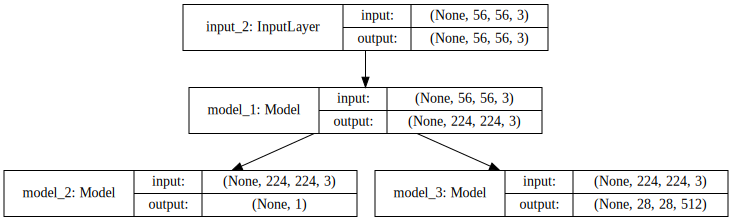

In [11]:
SVG(model_to_dot(combined, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
path = "./mainDataset"
dataset_name = "train"
# for the VGG feature out true labels
ni = np.sqrt(batch_size)
#disc_patch = (14, 14, 1)

In [11]:
def readImage(x,p):
    img = cv2.imread(p+x,cv2.IMREAD_COLOR)
    return img

In [12]:
train_hr_img_list = sorted(tl.files.load_file_list(path=path+'/%s/' % (dataset_name), regx='.*.png', printable=False))
#train_hr_imgs = tl.vis.read_images(train_hr_img_list[0:100], path=path+'/%s/' % (dataset_name), n_threads=32)
train_hr_imgs = tl.prepro.threading_data(train_hr_img_list,fn=readImage,p=path+'/%s/' % (dataset_name))

In [13]:
train_hr_imgs_clean = []
for i,img in enumerate(train_hr_imgs):
    if img is not None:
        train_hr_imgs_clean.append(img)
train_hr_imgs = np.array(train_hr_imgs_clean)

In [14]:
steps = len(train_hr_imgs)//batch_size
'''
IdealEpochs = 100000/steps
'''
#epochs = 400

'\nIdealEpochs = 100000/steps\n'

In [15]:
def scaleHR(x):
    x = x / (255. / 2.)
    x = x - 1.
    return x

def scaleLR(x):
    x = cv2.GaussianBlur(x,(3,3),0)
    x = x / 255.
    return x
    
def datagen(dev_hr_imgs,batchSize,is_testing=False):
    while(True):
        imgs_hr=[]
        imgs_lr=[]
        imgs = np.random.choice(dev_hr_imgs,batchSize)
        #img_hr = tl.prepro.threading_data(imgs, fn=crop, wrg=224, hrg=224, is_random=True)
        img_hr = tl.prepro.threading_data(imgs, fn=imresize,size=[224, 224], interp='bicubic', mode=None)
        img_lr = tl.prepro.threading_data(imgs, fn=imresize,size=[56, 56], interp='bicubic', mode=None)
        
        imgs_hr = tl.prepro.threading_data(img_hr,fn=scaleHR)
        imgs_lr = tl.prepro.threading_data(img_lr,fn=scaleLR)
        
        yield imgs_hr, imgs_lr

In [16]:
datagenObj = datagen(train_hr_imgs,batch_size)

In [17]:
sample_hr,sample_lr = next(datagenObj)

In [18]:
tl.vis.save_images(sample_hr, [int(ni), int(ni)],'images/'+dataset_name+'/sample_hr.png')
tl.vis.save_images(sample_lr, [int(ni), int(ni)],'images/'+dataset_name+'/sample_lr.png')

In [19]:
tensorboard = TensorBoard(
  log_dir='log/srgan_replication/SRResNet/run7',
  histogram_freq=0,
  batch_size=batch_size,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(SRGAN_gen)

In [69]:
'''
run 5 higher LR
run 6 Bigger resnet
run 7 resize instead of crop
'''

'\nrun 5 higher LR\nrun 6 Bigger resnet\n'

In [20]:
modelcheckpoint = ModelCheckpoint(
    filepath = "./checkpoints/genInitMC.h5",
    monitor='g_loss',
    verbose=0,
    mode="auto",
    save_best_only=True
)
modelcheckpoint.set_model(SRGAN_gen)

In [ ]:
for epoch in range(100):
    print("Epoch:"+str(epoch))
    for step in tqdm_notebook(range(0,steps)):
        imgs_hr, imgs_lr = next(datagenObj)

        # Train the generators
        g_loss = SRGAN_gen.train_on_batch(imgs_lr,imgs_hr)
        
    mc_step = epoch*steps + steps
    modelcheckpoint.on_epoch_end(mc_step,{"g_loss":g_loss})
    out = SRGAN_gen.predict(sample_lr)
    tl.vis.save_images(out, [int(ni), int(ni)],'images/'+dataset_name+'/train.png')
    tensorboard.on_epoch_end(epoch, {"g_loss": g_loss})
    if(epoch % 10 == 0):
        out = SRGAN_gen.predict(sample_lr)
        tl.vis.save_images(out, [int(ni), int(ni)],'images/'+dataset_name+'/trainSRResNet_%d.png' % int(epoch))

Epoch:0


Instructions for updating:
Use tf.cast instead.

Epoch:1



Epoch:2



Epoch:3



Epoch:4



Epoch:5



Epoch:6



Epoch:7



Epoch:8



Epoch:9



Epoch:10



Epoch:11



Epoch:12



Epoch:13



Epoch:14



Epoch:15



Epoch:16



Epoch:17



Epoch:18



Epoch:19



Epoch:20



Epoch:21



Epoch:22



Epoch:23



Epoch:24



Epoch:25



Epoch:26



Epoch:27



Epoch:28



Epoch:29



Epoch:30



Epoch:31



Epoch:32



Epoch:33



Epoch:34



Epoch:35



Epoch:36



Epoch:37



Epoch:38



Epoch:39



Epoch:40



Epoch:41



Epoch:42



Epoch:43



Epoch:44



Epoch:45



Epoch:46



Epoch:47



Epoch:48



Epoch:49



Epoch:50



Epoch:51



Epoch:52



Epoch:53



Epoch:54



Epoch:55



Epoch:56



Epoch:57



Epoch:58



Epoch:59



Epoch:60



Epoch:61



Epoch:62



Epoch:63



Epoch:64



Epoch:65



Epoch:66



Epoch:67



Epoch:68



Epoch:69



Epoch:70



Epoch:71



Epoch:72



Epoch:73



Epoch:74



Epoch:75



Epoch:76



Epoch:77



Epoch:78



Epoch:79



Epoch:80



Epoch:81



Epoch:82



Epoch:83



Epoch:84



Epoch:85



Epoch:86



Epoch:87



Epoch:88



Epoch:89



Epoch:90



Epoch:91



Epoch:92



Epoch:93


In [54]:
SRGAN_gen.load_weights("checkpoints/genInitMC.h5")

In [57]:
modelcheckpoint = ModelCheckpoint(
    filepath = "./checkpoints/genMC.h5",
    monitor='g_loss',
    verbose=0,
    mode="auto",
    save_best_only=True
)
modelcheckpoint.set_model(SRGAN_gen)

In [58]:
tensorboard = TensorBoard(
  log_dir='log/srgan_replication/SRGAN_main/run8',
  histogram_freq=0,
  batch_size=batch_size,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(combined)

In [ ]:
# run 5 and 6 good
# 7 higher LR
# 8 bigger resnet

In [61]:
for epoch in range(300):
    print("Epoch:"+str(epoch))
    for step in tqdm_notebook(range(0,steps)):
        # Sample images and their conditioning counterparts
        imgs_hr, imgs_lr = next(datagenObj)
        # From low res. image generate high res. version
        fake_hr = SRGAN_gen.predict(imgs_lr)
        valid = np.ones(batch_size,) - np.random.sample(batch_size,)*0.3
        fake = np.random.sample(batch_size,)*0.3
        if step % 2 == 0:
            # ----------------------
            #  Train Discriminator
            # ----------------------
            # Train the discriminators (original images = real / generated = Fake)
            SRGAN_disc.trainable = True
            d_loss = SRGAN_disc.train_on_batch(np.concatenate([imgs_hr,fake_hr]), np.concatenate([valid,fake]).reshape(32,1))
            SRGAN_disc.trainable = False
            
        else:
            # ------------------
            #  Train Generator
            # ------------------

            # The generators want the discriminators to label the generated images as real

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = vggModel.predict(imgs_hr)

            # Train the generators
            g_loss = combined.train_on_batch(imgs_lr, [valid, image_features])
        
    mc_step = epoch*steps + steps
    modelcheckpoint.on_epoch_end(mc_step,{"g_loss":g_loss[2]})   
    out = SRGAN_gen.predict(sample_lr)
    tl.vis.save_images(out, [int(ni), int(ni)],'images/'+dataset_name+'/train.png')
    if(epoch % 100 == 0):
        out = SRGAN_gen.predict(sample_lr)
        tl.vis.save_images(out, [int(ni), int(ni)],'images/'+dataset_name+'/HardTrain_%d.png' % int(epoch))
    tensorboard.on_epoch_end(epoch, {"d_loss": d_loss[0],"d_acc":d_loss[1],"g_l0":g_loss[0], "g_l1":g_loss[1], "g_vgg_loss":g_loss[2]})
    combined.save_weights("checkpoints/combined.h5")
tensorboard.on_train_end(None)

Epoch:0


Epoch:1


Epoch:2


Epoch:3


Epoch:4


Epoch:5


Epoch:6


Epoch:7


Epoch:8


Epoch:9


Epoch:10


Epoch:11


Epoch:12


Epoch:13


Epoch:14


Epoch:15


Epoch:16


Epoch:17


Epoch:18


Epoch:19


KeyboardInterrupt: 

In [ ]:
tensorboard = TensorBoard(
  log_dir='log/srgan_replication/SRGAN_soft/run10',
  histogram_freq=0,
  batch_size=batch_size,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(combined)

In [ ]:
modelcheckpoint = ModelCheckpoint(
    filepath = modelSavePath+"genSoft.h5",
    monitor='g_loss',
    verbose=0,
    mode="auto",
    save_best_only=True
)
modelcheckpoint.set_model(SRGAN_gen)

In [26]:
optimizer = Adam(lr=0.00001, beta_1=0.9)

SRGAN_disc = Discriminator(hr_shape)
SRGAN_disc.trainable = False
SRGAN_disc.compile(loss='mean_squared_error',
             optimizer=optimizer,
             metrics=['binary_accuracy'])
combined.compile(loss=['binary_crossentropy', 'mean_squared_error'],
                 loss_weights=[1e-3, 0.006],
                 optimizer=optimizer)

combined.load_weights("checkpoints/combined.h5")

In [ ]:
for epoch in range(2000):
    print("Epoch:"+str(epoch))
    for step in tqdm_notebook(range(0,steps)):
        # Sample images and their conditioning counterparts
        imgs_hr, imgs_lr = next(datagenObj)
        # From low res. image generate high res. version
        fake_hr = SRGAN_gen.predict(imgs_lr)
        if step % 2 == 0:
            # ----------------------
            #  Train Discriminator
            # ----------------------
            
            valid = np.ones(batch_size)
            fake = np.zeros(batch_size)

            # Train the discriminators (original images = real / generated = Fake)
            SRGAN_disc.trainable = True
            d_loss_real = SRGAN_disc.train_on_batch(imgs_hr, valid)
            d_loss_fake = SRGAN_disc.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            SRGAN_disc.trainable = False
            
        else:
            # ------------------
            #  Train Generator
            # ------------------

            # The generators want the discriminators to label the generated images as real
            valid = np.ones(batch_size)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = vggModel.predict(imgs_hr)

            # Train the generators
            g_loss = combined.train_on_batch(imgs_lr, [valid, image_features])
    
    mc_step = epoch*steps + steps
    modelcheckpoint.on_epoch_end(mc_step,{"g_loss":g_loss[1]})
    out = SRGAN_gen.predict(sample_lr)
    tl.vis.save_images(out, [int(ni), int(ni)],'images/'+dataset_name+'/train.png')
    if(epoch % 100 == 0):
        out = SRGAN_gen.predict(sample_lr)
        tl.vis.save_images(out, [int(ni), int(ni)],'images/'+dataset_name+'/softTrain_%d.png' % int(epoch))
    tensorboard.on_epoch_end(epoch, {"d_loss": d_loss[0],"d_acc":d_loss[1],"g_vgg_loss":g_loss[1]})
combined.save_weights("checkpoints/combinedSoft.h5")
tensorboard.on_train_end(None)